<img src="https://github.com/pmservice/ai-openscale-tutorials/raw/master/notebooks/images/banner.png" align="left" alt="banner">

# Working with Custom Machine Learning engine

This notebook shows how to log the payload for the model deployed on custom model serving engine using Watson OpenScale python sdk.

### Contents

- [Setup](#setup)
- [OpenScale configuration](#openscale)
- [Performance monitor, scoring and payload logging](#performance)
- [Quality monitor and feedback logging](#quality)
- [Fairness monitoring and explanations](#fairness)
- [Custom monitors and metrics](#custom)
- [Payload analytics](#analytics)

# Setup <a name="setup"></a>

## Custom machine learning engine example

The sample machine learning engine code (python flask) and deployment instructions can be found [here](https://github.com/pmservice/ai-openscale-tutorials/tree/master/applications/custom-ml-engine-bluemix).

Follow up intructions and deploy your own instance of the custom engine application.

**NOTE:** CUSTOM machine learning engine must follow this [API specification](https://aiopenscale-custom-deployement-spec.mybluemix.net/) to be supported.

## Packages and credentials

In [1]:
!pip install --upgrade ibm-ai-openscale --no-cache | tail -n 1

In [2]:
!pip install pyspark | tail -n 1
!pip install lime | tail -n 1
!pip install pixiedust | tail -n 1

Requirement not upgraded as not directly required: certifi>=2017.4.17 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from requests->pixiedust)


Import and initiate.

In [3]:
from ibm_ai_openscale import APIClient
from ibm_ai_openscale.supporting_classes import PayloadRecord
from ibm_ai_openscale.engines import *
from ibm_ai_openscale.utils import *
import pandas as pd

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### ACTION: Get OpenScale `instance_guid` and `apikey`

How to install IBM Cloud (bluemix) console: [instruction](https://console.bluemix.net/docs/cli/reference/ibmcloud/download_cli.html#install_use)

How to get api key using bluemix console:
```
bx login --sso
bx iam api-key-create 'my_key'
```

How to get your OpenScale instance GUID

- if your resource group is different than `default` switch to resource group containing OpenScale instance
```
bx target -g <myResourceGroup>
```
- get details of the instance
```
bx resource service-instance 'AI-OpenScale-instance_name'
```

#### Let's define some constants required to set up data mart:

- AIOS_CREDENTIALS
- POSTGRES_CREDENTIALS
- SCHEMA_NAME

In [4]:
AIOS_CREDENTIALS = {
  "url": "https://api.aiopenscale.cloud.ibm.com",
  "instance_guid": "***",
  "apikey": "***"
}

In [5]:
# The code was removed by Watson Studio for sharing.

In [6]:
POSTGRES_CREDENTIALS = {
    "db_type": "postgresql",
    "uri_cli_1": "xxx",
    "maps": [],
    "instance_administration_api": {
        "instance_id": "xxx",
        "root": "xxx",
        "deployment_id": "xxx"
    },
    "name": "xxx",
    "uri_cli": "xxx",
    "uri_direct_1": "xxx",
    "ca_certificate_base64": "xxx",
    "deployment_id": "xxx",
    "uri": "xxx"
}

In [7]:
# The code was removed by Watson Studio for sharing.

In [8]:
SCHEMA_NAME = 'custom_ml_engine'

Create schema for data mart.

In [9]:
create_postgres_schema(postgres_credentials=POSTGRES_CREDENTIALS, schema_name=SCHEMA_NAME)

In [10]:
client = APIClient(AIOS_CREDENTIALS)

In [11]:
client.version

'2.1.6'

## Training data

#### Get training data set from git

In [47]:
!rm credit_risk_training.csv 
!wget https://raw.githubusercontent.com/pmservice/wml-sample-models/master/spss/credit-risk/data/credit_risk_training.csv

--2019-04-04 10:32:58--  https://raw.githubusercontent.com/pmservice/wml-sample-models/master/spss/credit-risk/data/credit_risk_training.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 694222 (678K) [text/plain]
Saving to: ‘credit_risk_training.csv’

100%[======================================>] 694,222     --.-K/s   in 0.02s   

2019-04-04 10:32:58 (29.9 MB/s) - ‘credit_risk_training.csv’ saved [694222/694222]



### Preview data

In [43]:
data_df = pd.read_csv("credit_risk_training.csv",
                    dtype={'LoanDuration': int, 'LoanAmount': int, 'InstallmentPercent': int, 'CurrentResidenceDuration': int, 'Age': int, 'ExistingCreditsCount': int, 'Dependents': int})

In [48]:
data_df

,CheckingStatus,LoanDuration,CreditHistory,LoanPurpose,LoanAmount,ExistingSavings,EmploymentDuration,InstallmentPercent,Sex,OthersOnLoan,...,OwnsProperty,Age,InstallmentPlans,Housing,ExistingCreditsCount,Job,Dependents,Telephone,ForeignWorker,Risk
0,0_to_200,31,credits_paid_to_date,other,1889,100_to_500,less_1,3,female,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
1,less_0,18,credits_paid_to_date,car_new,462,less_100,1_to_4,2,female,none,...,savings_insurance,37,stores,own,2,skilled,1,none,yes,No Risk
2,less_0,15,prior_payments_delayed,furniture,250,less_100,1_to_4,2,male,none,...,real_estate,28,none,own,2,skilled,1,yes,no,No Risk
3,0_to_200,28,credits_paid_to_date,retraining,3693,less_100,greater_7,3,male,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
4,no_checking,28,prior_payments_delayed,education,6235,500_to_1000,greater_7,3,male,none,...,unknown,57,none,own,2,skilled,1,none,yes,Risk
5,no_checking,32,outstanding_credit,vacation,9604,500_to_1000,greater_7,6,male,co-applicant,...,unknown,57,none,free,2,skilled,2,yes,yes,Risk
6,no_checking,9,prior_payments_delayed,car_new,1032,100_to_500,4_to_7,3,male,none,...,savings_insurance,41,none,own,1,management_self-employed,1,none,yes,No Risk
7,less_0,16,credits_paid_to_date,vacation,3109,less_100,4_to_7,3,female,none,...,car_other,36,none,own,2,skilled,1,none,yes,No Risk
8,0_to_200,11,credits_paid_to_date,car_new,4553,less_100,less_1,3,female,none,...,savings_insurance,22,none,own,1,management_self-employed,1,none,yes,No Risk
9,no_checking,35,outstanding_credit,appliances,7138,500_to_1000,greater_7,5,male,co-applicant,...,unknown,49,none,free,2,skilled,2,yes,yes,Risk


# OpenScale configuration <a name="openscale"></a>

## DataMart setup

In [16]:
client.data_mart.setup(db_credentials=POSTGRES_CREDENTIALS, schema=SCHEMA_NAME)

In [17]:
data_mart_details = client.data_mart.get_details()

## Bind machine learning engines

### Bind  `CUSTOM` machine learning engine
**NOTE:** CUSTOM machine learning engine must follow this [API specification](https://aiopenscale-custom-deployement-spec.mybluemix.net/) to be supported.

Credentials support following fields:
- `url` - hostname and port (required)
- `username` - part of BasicAuth (optional)
- `password` - part of BasicAuth (optional)

In [18]:
CUSTOM_ENGINE_CREDENTIALS = {
    "url": "***",
    "username": "***",
    "password": "***"
}

In [19]:
# The code was removed by Watson Studio for sharing.

In [20]:
binding_uid = client.data_mart.bindings.add('My custom engine', CustomMachineLearningInstance(CUSTOM_ENGINE_CREDENTIALS))

In [21]:
bindings_details = client.data_mart.bindings.get_details()

In [22]:
client.data_mart.bindings.list()

3e949909-dc80-4c09-9968-c55019d272df,My custom engine,custom_machine_learning,2019-04-04T10:30:05.277Z


## Subscriptions

### Add subscriptions

List available deployments.

In [23]:
client.data_mart.bindings.list_assets()

credit,credit,2019-01-01T10:11:12Z,model,,3e949909-dc80-4c09-9968-c55019d272df,False
resnet50,resnet50,2016-12-01T10:11:12Z,model,,3e949909-dc80-4c09-9968-c55019d272df,False
action,area and action prediction,2016-12-01T10:11:12Z,model,,3e949909-dc80-4c09-9968-c55019d272df,False


Let's specify training data information like: list of features and list of categorical features required by fairness and explain.

In [24]:
feature_columns = ['CheckingStatus', 'LoanDuration', 'CreditHistory', 'LoanPurpose', 'LoanAmount', 'ExistingSavings', 'EmploymentDuration', 'InstallmentPercent', 'Sex', 'OthersOnLoan', 'CurrentResidenceDuration', 'OwnsProperty', 'Age', 'InstallmentPlans', 'Housing', 'ExistingCreditsCount', 'Job', 'Dependents', 'Telephone', 'ForeignWorker']
categorical_columns = ['CheckingStatus', 'CreditHistory', 'LoanPurpose', 'ExistingSavings', 'EmploymentDuration', 'Sex', 'OthersOnLoan', 'OwnsProperty', 'InstallmentPlans','Housing', 'Job', 'Telephone', 'ForeignWorker']

In [25]:
subscription = client.data_mart.subscriptions.add(
    CustomMachineLearningAsset(
                source_uid='credit',
                label_column='Risk',
                prediction_column='prediction',
                probability_column='probability',
                feature_columns=feature_columns.copy(),
                categorical_columns=categorical_columns.copy(),
                binding_uid=binding_uid))

### Get subscriptions list

In [26]:
subscriptions = client.data_mart.subscriptions.get_details()

In [27]:
subscriptions_uids = client.data_mart.subscriptions.get_uids()
print(subscriptions_uids)

['credit']


### List subscriptions

In [28]:
client.data_mart.subscriptions.list()

credit,credit,model,3e949909-dc80-4c09-9968-c55019d272df,2019-04-04T10:30:12.663Z


# Performance metrics, scoring and payload logging <a id="performance"></a>

## Score the credit model

In [29]:
import requests
import time

values = [
            ["no_checking", 13, "credits_paid_to_date", "car_new", 1343, "100_to_500", "1_to_4", 2, "female", "none", 3,
             "savings_insurance", 25, "none", "own", 2, "skilled", 1, "none", "yes"],
            ["no_checking", 24, "prior_payments_delayed", "furniture", 4567, "500_to_1000", "1_to_4", 4, "male", "none",
             4, "savings_insurance", 60, "none", "free", 2, "management_self-employed", 1, "none", "yes"],
            ["0_to_200", 26, "all_credits_paid_back", "car_new", 863, "less_100", "less_1", 2, "female", "co-applicant",
             2, "real_estate", 38, "none", "own", 1, "skilled", 1, "none", "yes"],
            ["0_to_200", 14, "no_credits", "car_new", 2368, "less_100", "1_to_4", 3, "female", "none", 3, "real_estate",
             29, "none", "own", 1, "skilled", 1, "none", "yes"],
            ["0_to_200", 4, "no_credits", "car_new", 250, "less_100", "unemployed", 2, "female", "none", 3,
             "real_estate", 23, "none", "rent", 1, "management_self-employed", 1, "none", "yes"],
            ["no_checking", 17, "credits_paid_to_date", "car_new", 832, "100_to_500", "1_to_4", 2, "male", "none", 2,
             "real_estate", 42, "none", "own", 1, "skilled", 1, "none", "yes"],
            ["no_checking", 50, "outstanding_credit", "appliances", 5696, "unknown", "greater_7", 4, "female",
             "co-applicant", 4, "unknown", 54, "none", "free", 2, "skilled", 1, "yes", "yes"],
            ["0_to_200", 13, "prior_payments_delayed", "retraining", 1375, "100_to_500", "4_to_7", 3, "male", "none", 3,
             "real_estate", 70, "none", "own", 2, "management_self-employed", 1, "none", "yes"]
        ]


request_data = {'fields': feature_columns, 'values': values}

header = {'Content-Type': 'application/json'}
scoring_url = subscription.get_details()['entity']['deployments'][0]['scoring_endpoint']['url']

start_time = time.time()
response = requests.post(scoring_url, json=request_data, headers=header)
response_time = int((time.time() - start_time)*1000)

response_data = response.json()
print('Response: ' + str(response_data))

Response: {'values': [['No Risk', [0.8823126094462725, 0.1176873905537274]], ['No Risk', [0.6755090846150376, 0.3244909153849625]], ['No Risk', [0.8944991421537971, 0.10550085784620292]], ['No Risk', [0.9297263621482206, 0.07027363785177945]], ['No Risk', [0.937346474163384, 0.06265352583661594]], ['No Risk', [0.8389265131291409, 0.16107348687085907]], ['Risk', [0.16270903114445467, 0.8372909688555453]], ['No Risk', [0.8011704003481404, 0.1988295996518596]]], 'fields': ['prediction', 'probability'], 'labels': ['Risk', 'No Risk']}


## Store the request and response in payload logging table

#### Using Python SDK

**Hint:** You can embed payload logging code into your custom deployment so it is logged automatically each time you score the model.

In [30]:
records_list = [PayloadRecord(request=request_data, response=response_data, response_time=response_time), 
                PayloadRecord(request=request_data, response=response_data, response_time=response_time)]

for i in range(1, 10):
    records_list.append(PayloadRecord(request=request_data, response=response_data, response_time=response_time))

subscription.payload_logging.store(records=records_list)

#### Using REST API

Get the token first.

In [31]:
token_endpoint = "https://iam.bluemix.net/identity/token"
headers = {
    "Content-Type": "application/x-www-form-urlencoded",
    "Accept": "application/json"
}

data = {
    "grant_type":"urn:ibm:params:oauth:grant-type:apikey",
    "apikey":AIOS_CREDENTIALS["apikey"]
}

req = requests.post(token_endpoint, data=data, headers=headers)
token = req.json()['access_token']

Store the payload.

In [32]:
import requests, uuid

PAYLOAD_STORING_HREF_PATTERN = '{}/v1/data_marts/{}/scoring_payloads'
endpoint = PAYLOAD_STORING_HREF_PATTERN.format(AIOS_CREDENTIALS['url'], AIOS_CREDENTIALS['data_mart_id'])

payload = [{
    'binding_id': binding_uid, 
    'deployment_id': subscription.get_details()['entity']['deployments'][0]['deployment_id'], 
    'subscription_id': subscription.uid, 
    'scoring_id': str(uuid.uuid4()), 
    'response': response_data,
    'request': request_data
}]


headers = {"Authorization": "Bearer " + token}
      
req_response = requests.post(endpoint, json=payload, headers = headers)

print("Request OK: " + str(req_response.ok))

Request OK: True


## Performance metrics of scoring requests

In [33]:
subscription.performance_monitoring.show_table()

2019-04-04 10:30:25.211000+00:00,18.0,8,3e949909-dc80-4c09-9968-c55019d272df,credit,german_credit_risk,,
2019-04-04 10:30:25.211000+00:00,18.0,8,3e949909-dc80-4c09-9968-c55019d272df,credit,german_credit_risk,,
2019-04-04 10:30:25.211000+00:00,18.0,8,3e949909-dc80-4c09-9968-c55019d272df,credit,german_credit_risk,,
2019-04-04 10:30:25.211000+00:00,18.0,8,3e949909-dc80-4c09-9968-c55019d272df,credit,german_credit_risk,,
2019-04-04 10:30:25.211000+00:00,18.0,8,3e949909-dc80-4c09-9968-c55019d272df,credit,german_credit_risk,,
2019-04-04 10:30:25.211000+00:00,18.0,8,3e949909-dc80-4c09-9968-c55019d272df,credit,german_credit_risk,,
2019-04-04 10:30:25.211000+00:00,18.0,8,3e949909-dc80-4c09-9968-c55019d272df,credit,german_credit_risk,,
2019-04-04 10:30:25.211000+00:00,18.0,8,3e949909-dc80-4c09-9968-c55019d272df,credit,german_credit_risk,,
2019-04-04 10:30:25.211000+00:00,18.0,8,3e949909-dc80-4c09-9968-c55019d272df,credit,german_credit_risk,,
2019-04-04 10:30:25.211000+00:00,18.0,8,3e949909-dc80-4c09-9968-c55019d272df,credit,german_credit_risk,,


# Feedback logging & quality (accuracy) monitoring <a id="quality"></a>

## Enable quality monitoring

You need to provide the monitoring `threshold` and `min_records` (minimal number of feedback records).

In [34]:
subscription.quality_monitoring.enable(threshold=0.8, min_records=10)

### Feedback records logging

Feedback records are used to evaluate your model. The predicted values are compared to real values (feedback records).

You can check the schema of feedback table using below method.

In [35]:
subscription.feedback_logging.print_table_schema()

CheckingStatus,string,True
LoanDuration,integer,True
CreditHistory,string,True
LoanPurpose,string,True
LoanAmount,integer,True
ExistingSavings,string,True
EmploymentDuration,string,True
InstallmentPercent,integer,True
Sex,string,True
OthersOnLoan,string,True
CurrentResidenceDuration,integer,True


The feedback records can be send to feedback table using below code.

In [36]:
records = [
    ["no_checking","28","outstanding_credit","appliances","5990","500_to_1000","greater_7","5","male","co-applicant","3","car_other","55","none","free","2","skilled","2","yes","yes","Risk"],
    ["greater_200","22","all_credits_paid_back","car_used","3376","less_100","less_1","3","female","none","2","car_other","32","none","own","1","skilled","1","none","yes","No Risk"],
    ["no_checking","39","credits_paid_to_date","vacation","6434","unknown","greater_7","5","male","none","4","car_other","39","none","own","2","skilled","2","yes","yes","Risk"],
    ["0_to_200","20","credits_paid_to_date","furniture","2442","less_100","unemployed","3","female","none","1","real_estate","42","none","own","1","skilled","1","none","yes","No Risk"],
    ["greater_200","4","all_credits_paid_back","education","4206","less_100","unemployed","1","female","none","3","savings_insurance","27","none","own","1","management_self-employed","1","none","yes","No Risk"],
    ["greater_200","23","credits_paid_to_date","car_used","2963","greater_1000","greater_7","4","male","none","4","car_other","46","none","own","2","skilled","1","none","yes","Risk"],
    ["no_checking","31","prior_payments_delayed","vacation","2673","500_to_1000","1_to_4","3","male","none","2","real_estate","35","stores","rent","1","skilled","2","none","yes","Risk"],
    ["no_checking","37","prior_payments_delayed","other","6971","500_to_1000","1_to_4","3","male","none","3","savings_insurance","54","none","own","2","skilled","1","yes","yes","Risk"],
    ["0_to_200","39","prior_payments_delayed","appliances","5685","100_to_500","1_to_4","4","female","none","2","unknown","37","none","own","2","skilled","1","yes","yes","Risk"],
    ["no_checking","38","prior_payments_delayed","appliances","4990","500_to_1000","greater_7","4","male","none","4","car_other","50","bank","own","2","unemployed","2","yes","yes","Risk"]]

fields = feature_columns.copy()
fields.append('Risk')

subscription.feedback_logging.store(feedback_data=records, fields=fields)

## Run quality monitoring on demand

By default, quality monitoring is run on hourly schedule. You can also trigger it on demand using below code.

In [37]:
run_details = subscription.quality_monitoring.run(background_mode=False)




 Waiting for end of quality monitoring run d843c6cc-861f-4619-939d-e5b4d4590542 




initializing
completed

---------------------------
 Successfully finished run 
---------------------------




### Show the quality metrics

In [38]:
subscription.quality_monitoring.show_table()

2019-04-04 10:30:33.360000+00:00,true_positive_rate,1.0,,,,3e949909-dc80-4c09-9968-c55019d272df,credit,german_credit_risk
2019-04-04 10:30:33.360000+00:00,area_under_roc,0.7142857142857143,0.8,,,3e949909-dc80-4c09-9968-c55019d272df,credit,german_credit_risk
2019-04-04 10:30:33.360000+00:00,precision,0.42857142857142855,,,,3e949909-dc80-4c09-9968-c55019d272df,credit,german_credit_risk
2019-04-04 10:30:33.360000+00:00,f1_measure,0.6,,,,3e949909-dc80-4c09-9968-c55019d272df,credit,german_credit_risk
2019-04-04 10:30:33.360000+00:00,accuracy,0.6,,,,3e949909-dc80-4c09-9968-c55019d272df,credit,german_credit_risk
2019-04-04 10:30:33.360000+00:00,log_loss,0.6451208770769135,,,,3e949909-dc80-4c09-9968-c55019d272df,credit,german_credit_risk
2019-04-04 10:30:33.360000+00:00,false_positive_rate,0.5714285714285714,,,,3e949909-dc80-4c09-9968-c55019d272df,credit,german_credit_risk
2019-04-04 10:30:33.360000+00:00,area_under_pr,0.42857142857142855,,,,3e949909-dc80-4c09-9968-c55019d272df,credit,german_credit_risk
2019-04-04 10:30:33.360000+00:00,recall,1.0,,,,3e949909-dc80-4c09-9968-c55019d272df,credit,german_credit_risk


Get all calculated metrics.

In [39]:
subscription.quality_monitoring.get_metrics(deployment_uid='action')

[{'binding_id': '3e949909-dc80-4c09-9968-c55019d272df',
  'metrics': [{'id': 'true_positive_rate', 'value': 1.0},
   {'id': 'area_under_roc', 'lower_limit': 0.8, 'value': 0.7142857142857143},
   {'id': 'precision', 'value': 0.42857142857142855},
   {'id': 'f1_measure', 'value': 0.6},
   {'id': 'accuracy', 'value': 0.6},
   {'id': 'log_loss', 'value': 0.6451208770769135},
   {'id': 'false_positive_rate', 'value': 0.5714285714285714},
   {'id': 'area_under_pr', 'value': 0.42857142857142855},
   {'id': 'recall', 'value': 1.0}],
  'monitor_definition_id': 'quality',
  'subscription_id': 'credit',
  'tags': [],
  'ts': '2019-04-04T10:30:33.360Z'}]

#### Get metrics as pandas dataframe

In [40]:
quality_pd = subscription.quality_monitoring.get_table_content(format='pandas')
quality_pd

,ts,id,value,lower limit,upper limit,tags,binding_id,subscription_id,deployment_id
0,2019-04-04 10:30:33.360000+00:00,true_positive_rate,1.000000,,,,3e949909-dc80-4c09-9968-c55019d272df,credit,german_credit_risk
1,2019-04-04 10:30:33.360000+00:00,area_under_roc,0.714286,0.8,,,3e949909-dc80-4c09-9968-c55019d272df,credit,german_credit_risk
2,2019-04-04 10:30:33.360000+00:00,precision,0.428571,,,,3e949909-dc80-4c09-9968-c55019d272df,credit,german_credit_risk
3,2019-04-04 10:30:33.360000+00:00,f1_measure,0.600000,,,,3e949909-dc80-4c09-9968-c55019d272df,credit,german_credit_risk
4,2019-04-04 10:30:33.360000+00:00,accuracy,0.600000,,,,3e949909-dc80-4c09-9968-c55019d272df,credit,german_credit_risk
5,2019-04-04 10:30:33.360000+00:00,log_loss,0.645121,,,,3e949909-dc80-4c09-9968-c55019d272df,credit,german_credit_risk
6,2019-04-04 10:30:33.360000+00:00,false_positive_rate,0.571429,,,,3e949909-dc80-4c09-9968-c55019d272df,credit,german_credit_risk
7,2019-04-04 10:30:33.360000+00:00,area_under_pr,0.428571,,,,3e949909-dc80-4c09-9968-c55019d272df,credit,german_credit_risk
8,2019-04-04 10:30:33.360000+00:00,recall,1.000000,,,,3e949909-dc80-4c09-9968-c55019d272df,credit,german_credit_risk


Create a bar plot.

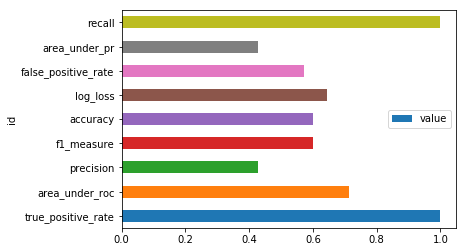

In [41]:
%matplotlib inline

quality_pd.plot.barh(x='id', y='value');

# Fairness monitoring and explanations <a id="fairness"></a>

## Enable and run fairness monitoring

In [49]:
from ibm_ai_openscale.supporting_classes import Feature

subscription.fairness_monitoring.enable(
            features=[
                Feature("Sex", majority=['male'], minority=['female'], threshold=0.95),
                Feature("Age", majority=[[26, 75]], minority=[[18, 25]], threshold=0.95)
            ],
            favourable_classes=['No Risk'],
            unfavourable_classes=['Risk'],
            min_records=4,
            training_data=data_df
        )

In [50]:
fairness_run = subscription.fairness_monitoring.run(background_mode=False)




 Counting bias for deployment_uid=german_credit_risk 




RUNNING
FINISHED

---------------------------
 Successfully finished run 
---------------------------




### Check fairness run results

In [51]:
subscription.fairness_monitoring.show_table()

2019-04-04 10:31:11.720276+00:00,Sex,female,False,1.0,100.0,3e949909-dc80-4c09-9968-c55019d272df,credit,credit,german_credit_risk,
2019-04-04 10:31:11.720276+00:00,Age,"[18, 25]",False,1.0,100.0,3e949909-dc80-4c09-9968-c55019d272df,credit,credit,german_credit_risk,
2019-04-04 10:32:10.379432+00:00,Sex,female,False,1.0,100.0,3e949909-dc80-4c09-9968-c55019d272df,credit,credit,german_credit_risk,
2019-04-04 10:32:10.379432+00:00,Age,"[18, 25]",False,1.0,100.0,3e949909-dc80-4c09-9968-c55019d272df,credit,credit,german_credit_risk,
2019-04-04 10:35:02.669312+00:00,Sex,female,False,1.0,100.0,3e949909-dc80-4c09-9968-c55019d272df,credit,credit,german_credit_risk,
2019-04-04 10:35:02.669312+00:00,Age,"[18, 25]",False,1.0,100.0,3e949909-dc80-4c09-9968-c55019d272df,credit,credit,german_credit_risk,


## Explainability configuration and run

### Enable explainability

In [52]:
subscription.explainability.enable(training_data=data_df)

#### Get sample transaction_id from payload logging table (`scoring_id`)

In [53]:
transaction_id = subscription.payload_logging.get_table_content(limit=1)['scoring_id'].values[0]

print(transaction_id)

389721db-ce32-46f7-b61d-978795432fff-1


### Run explanation for sample `transaction_id`

In [54]:
explain_run = subscription.explainability.run(transaction_id=transaction_id, background_mode=False)
        




 Looking for explanation for 389721db-ce32-46f7-b61d-978795432fff-1 




in_progress.
finished

---------------------------
 Successfully finished run 
---------------------------




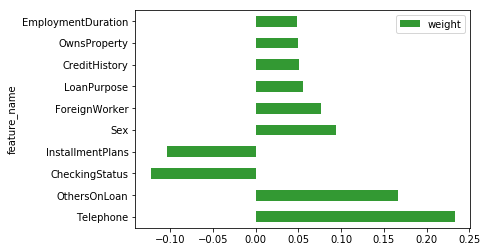

In [55]:
explain_result = pd.DataFrame.from_dict(explain_run['entity']['predictions'][0]['explanation_features'])
explain_result.plot.barh(x='feature_name', y='weight', color='g', alpha=0.8);

# Custom monitoring <a id="custom"></a>

## Register custom monitor

In [56]:
from ibm_ai_openscale.supporting_classes import Metric, Tag

metrics = [Metric(name='sensitivity', lower_limit_default=0.8), Metric(name='specificity', lower_limit_default=0.75)]
tags = [Tag(name='region', description='customer geographical region')]

my_monitor = client.data_mart.monitors.add(name='model performance', metrics=metrics, tags=tags)

In [57]:
client.data_mart.monitors.list()

quality,Accuracy Monitoring,None,"['area_under_roc', 'area_under_pr', 'explained_variance', 'mean_absolute_error', 'mean_squared_error', 'r2', 'root_mean_squared_error', 'accuracy', 'weighted_true_positive_rate', 'true_positive_rate', 'weighted_false_positive_rate', 'false_positive_rate', 'weighted_recall', 'recall', 'weighted_precision', 'precision', 'weighted_f_measure', 'f1_measure', 'log_loss']"
model_performance,model performance,None,"['sensitivity', 'specificity']"


#### Get `monitor_uid`

In [58]:
monitor_uid = my_monitor['metadata']['guid']

print(monitor_uid)

model_performance


#### Get monitor details

In [59]:
my_monitor = client.data_mart.monitors.get_details(monitor_uid=monitor_uid)
print('monitor definition details', my_monitor)

monitor definition details {'metadata': {'url': '/v1/data_marts/e3a38ab0-3884-454c-abc0-5e535eec36e6/monitor_definitions/model_performance', 'created_at': '2019-04-04T10:35:59.816Z', 'guid': 'model_performance'}, 'entity': {'name': 'model performance', 'tags': [{'id': 'region', 'name': 'region', 'required': True, 'description': 'customer geographical region'}], 'metrics': [{'id': 'sensitivity', 'name': 'sensitivity', 'required': True, 'thresholds': [{'default': 0.8, 'type': 'lower_limit'}]}, {'id': 'specificity', 'name': 'specificity', 'required': True, 'thresholds': [{'default': 0.75, 'type': 'lower_limit'}]}]}}


## Enable custom monitor for subscription

In [60]:
from ibm_ai_openscale.supporting_classes import Threshold

thresholds = [Threshold(metric_uid='sensitivity', lower_limit=0.9)]
subscription.monitoring.enable(monitor_uid=monitor_uid, thresholds=thresholds)

#### Get custom monitoring configuration details

In [61]:
subscription.monitoring.get_details(monitor_uid=monitor_uid)

{'enabled': True,
 'monitor_definition': {'entity': {'metrics': [{'id': 'sensitivity',
     'name': 'sensitivity',
     'required': True,
     'thresholds': [{'default': 0.9, 'type': 'lower_limit'}]},
    {'id': 'specificity', 'name': 'specificity', 'required': True}],
   'name': 'model performance',
   'tags': [{'description': 'customer geographical region',
     'id': 'region',
     'name': 'region',
     'required': True}]},
  'metadata': {'created_at': '2019-04-04T10:35:59.816Z',
   'guid': 'model_performance',
   'url': '/v1/data_marts/e3a38ab0-3884-454c-abc0-5e535eec36e6/monitor_definitions/model_performance'}},
 'thresholds': [{'metric_id': 'sensitivity',
   'type': 'lower_limit',
   'value': 0.9}]}

## Storing custom metrics

In [62]:
metrics = {"specificity": 0.78, "sensitivity": 0.67, "region": "us-south"}

subscription.monitoring.store_metrics(monitor_uid=monitor_uid, metrics=metrics)

### List and get custom metrics

In [63]:
subscription.monitoring.show_table(monitor_uid=monitor_uid)

2019-04-04 10:36:19.389092+00:00,sensitivity,0.67,0.9,,region: us-south,3e949909-dc80-4c09-9968-c55019d272df,credit,german_credit_risk
2019-04-04 10:36:19.389092+00:00,specificity,0.78,,,region: us-south,3e949909-dc80-4c09-9968-c55019d272df,credit,german_credit_risk


In [64]:
custom_metrics = subscription.monitoring.get_metrics(monitor_uid=monitor_uid, deployment_uid='credit')

In [65]:
custom_metrics

[{'binding_id': '3e949909-dc80-4c09-9968-c55019d272df',
  'metrics': [{'id': 'sensitivity', 'lower_limit': 0.9, 'value': 0.67},
   {'id': 'specificity', 'value': 0.78}],
  'monitor_definition_id': 'model_performance',
  'subscription_id': 'credit',
  'tags': [{'id': 'region', 'value': 'us-south'}],
  'ts': '2019-04-04T10:36:19.389092Z'}]

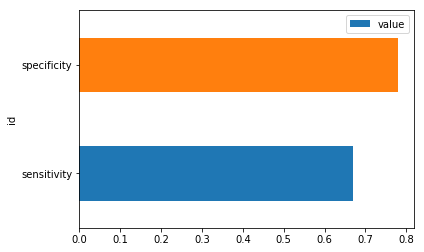

In [66]:
custom_metrics_pandas = subscription.monitoring.get_table_content(monitor_uid=monitor_uid)

%matplotlib inline
custom_metrics_pandas.plot.barh(x='id', y='value');

# Payload analytics <a id="analytics"></a>

## Run data distributions calculation

In [67]:
from datetime import datetime

start_date = "2018-01-01T00:00:00.00Z"
end_date = datetime.utcnow().isoformat() + "Z"

sex_distribution = subscription.payload_logging.data_distribution.run(
            start_date=start_date,
            end_date=end_date,
            group=['prediction', 'Sex'],
            agg=['count'])




 Waiting for end of data distribution run ade01d97-4a16-4363-bc76-fd20daba66be 




running
completed

---------------------------
 Successfully finished run 
---------------------------




## Get data distributions as pandas dataframe

In [68]:
sex_distribution_run_uid = sex_distribution['id']

In [69]:
distributions_pd = subscription.payload_logging.data_distribution.get_run_result(run_id=sex_distribution_run_uid, format='pandas')
distributions_pd

,prediction,Sex,count
0,No Risk,female,48
1,No Risk,male,36
2,Risk,female,12


## Visualize

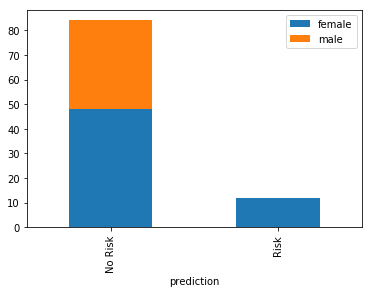

In [70]:
subscription.payload_logging.data_distribution.show_chart(sex_distribution_run_uid);

In [71]:
credit_history_distribution = subscription.payload_logging.data_distribution.run(
            start_date=start_date,
            end_date=end_date,
            group=['prediction', 'CreditHistory'],
            agg=['count'])




 Waiting for end of data distribution run 1263d9d5-140c-4878-9688-3d7a10e131a3 




running
completed

---------------------------
 Successfully finished run 
---------------------------




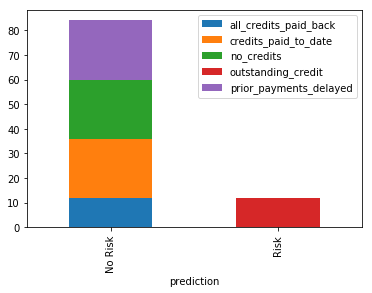

In [72]:
credit_history_distribution_run_uid = credit_history_distribution['id']

subscription.payload_logging.data_distribution.show_chart(credit_history_distribution_run_uid);

---

## Congratulations!

You have finished the tutorial for IBM Watson OpenScale and Azure Machine Learning Studio. You can now view the [OpenScale Dashboard](https://aiopenscale.cloud.ibm.com/). Click on the tile for the German Credit model to see fairness, accuracy, and performance monitors. Click on the timeseries graph to get detailed information on transactions during a specific time window.

---

### Authors
Lukasz Cmielowski, PhD, is an Automation Architect and Data Scientist at IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.